# Промышленность

<b>Задача проекта:<b>
    
  Предстоит построить модель, которая предскажет температуру стали для  металлургического  комбината ООО «Так закаляем сталь», поскольку комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План проекта
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

In [79]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [80]:
data_arc=pd.read_csv('/datasets/final_steel/data_arc.csv') 
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [81]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [82]:
print('Количество дубликатов в данных об электродах:',data_arc.isna().sum())

Количество дубликатов в данных об электродах: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [83]:
data_arc['Начало нагрева дугой']= pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y.%m.%d %H:%M:%S')
data_arc['Конец нагрева дугой']= pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y.%m.%d %H:%M:%S')

In [84]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [85]:
print('Количество дубликатов в данных об электродах:', data_arc.duplicated().sum())

Количество дубликатов в данных об электродах: 0


In [86]:
len(data_arc['key'].unique())

3214

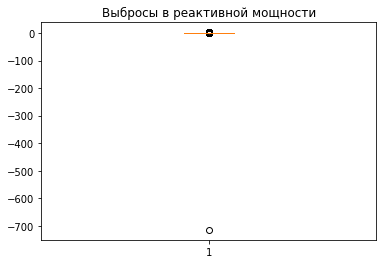

In [87]:
plt.boxplot(data_arc['Реактивная мощность'])
plt.title('Выбросы в реактивной мощности')
plt.show()

In [88]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

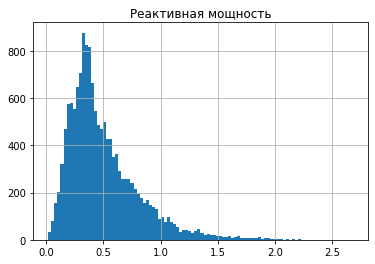

In [89]:
data_arc['Реактивная мощность'].hist(bins = 100)
plt.title('Реактивная мощность')
plt.show()

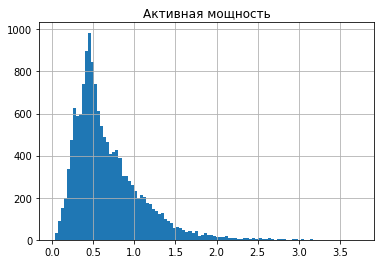

In [90]:
data_arc['Активная мощность'].hist(bins = 100)
plt.title('Активная мощность')
plt.show()

In [91]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

In [92]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds 

In [93]:
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172


В данных об электродах 14 876 строк, пропусков и дубликатов нет, есть явный выброс в Реактивной мощности- его я сразу удалила, построила гистограммы-видим нормальное распределение, поменяла тип данных даты. Номера партии повторяются

Также для работы нам понадобится Полная мощность, её высчитаем по формуле:
$$
S = \sqrt{P^{2} +Q^{2}}
$$

Где P - активная мощность, а Q -реактивная мощность
И понадобится новый признак  - Время нагрева, так же добавила.

In [94]:
data_bulk=pd.read_csv('/datasets/final_steel/data_bulk.csv') 
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [95]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [96]:
print('Количество пропусков в данных о подаче сыпучих материалов:',data_bulk.isna().sum())

Количество пропусков в данных о подаче сыпучих материалов: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [97]:
data_bulk = data_bulk.fillna(0)

In [98]:
print('Количество дубликатов в данных о подаче сыпучих материалов:', data_bulk.duplicated().sum())

Количество дубликатов в данных о подаче сыпучих материалов: 0


In [99]:
len(data_bulk['key'].unique()) 

3129

In [100]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [101]:
data_bulk_time=pd.read_csv('/datasets/final_steel/data_bulk_time.csv') 
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [102]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [103]:
print('Количество пропусков в данных о подаче сыпучих материалов(время):',data_bulk_time.isna().sum())

Количество пропусков в данных о подаче сыпучих материалов(время): key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


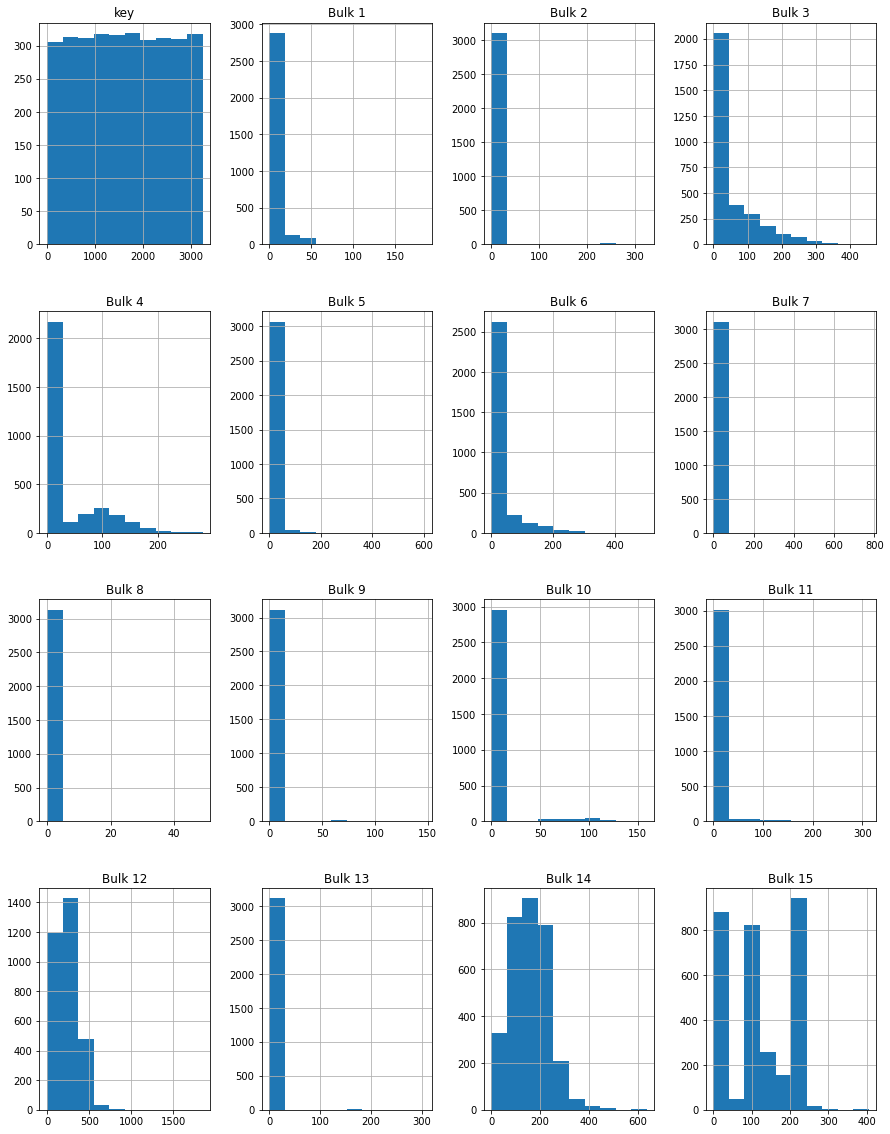

In [104]:
data_bulk.hist(grid=True, figsize=(15, 20))
plt.show()

In [105]:
data_gas=pd.read_csv('/datasets/final_steel/data_gas.csv') 
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [106]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [107]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


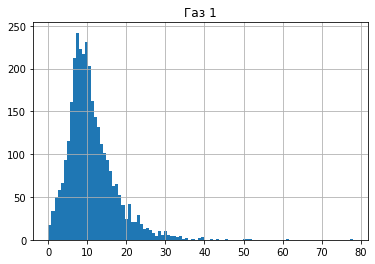

In [108]:
data_gas.hist(['Газ 1'], bins=100)
plt.title('Газ 1')
plt.show()

In [109]:
len(data_gas['key'].unique()) 

3239

In [110]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

In [111]:
data_temp=pd.read_csv('/datasets/final_steel/data_temp.csv') 
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [112]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [113]:
print('Количество дубликатов в данных о результатах измерения температуры:', data_temp.duplicated().sum())

Количество дубликатов в данных о результатах измерения температуры: 0


In [114]:
print('Количество пропусков в данных о подаче сыпучих материалов:',data_temp.isna().sum())

Количество пропусков в данных о подаче сыпучих материалов: key                0
Время замера       0
Температура     2901
dtype: int64


In [115]:
data_temp[data_temp['Температура'].isnull()].tail()

,key,Время замера,Температура
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [116]:
data_temp['Температура']= data_temp['Температура'].fillna(-100)

In [117]:
temp_unknown = data_temp.loc[data_temp.loc[:, 'Температура'] == -100]
temp_unknown

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,-100.0
12269,2500,2019-08-06 03:25:16,-100.0
12270,2500,2019-08-06 03:28:21,-100.0
12272,2501,2019-08-06 04:01:59,-100.0
12273,2501,2019-08-06 04:14:35,-100.0
...,...,...,...
15901,3240,2019-09-01 03:35:16,-100.0
15903,3241,2019-09-01 04:16:12,-100.0
15904,3241,2019-09-01 04:22:39,-100.0
15905,3241,2019-09-01 04:33:42,-100.0


In [118]:
data_temp = data_temp.query('key < 2500')

В температуре есть пропуски, проверили по каким партиям нет замера температуры, получаетсяпо партиям начиная с 2500, удалила их

In [119]:
len(data_temp['key'].unique())

2477

In [120]:
data_temp['Время замера']= pd.to_datetime(data_temp['Время замера'], format='%Y.%m.%d %H:%M:%S')

In [121]:
print('Количество пропусков в данных о подаче сыпучих материалов:',data_temp.isna().sum())

Количество пропусков в данных о подаче сыпучих материалов: key             0
Время замера    0
Температура     0
dtype: int64


In [122]:
data_temp.describe()

,key,Температура
count,12267.000000,12267.000000
mean,1235.589060,1591.999022
std,729.452481,20.833175
min,1.000000,1191.000000
25%,602.000000,1581.000000
50%,1238.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1705.000000


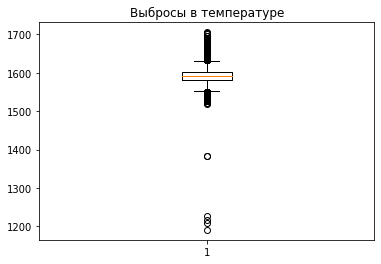

In [123]:
plt.boxplot(data_temp['Температура'])
plt.title('Выбросы в температуре')
plt.show()

In [124]:
data_temp = data_temp[data_temp['Температура'] > 100]

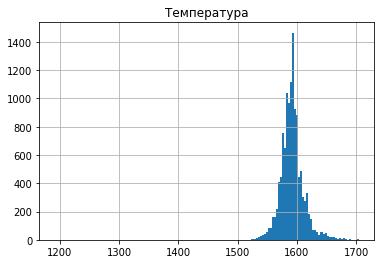

In [125]:
data_temp.hist(['Температура'], bins=150)
plt.title('Температура')
plt.show()

In [126]:
data_wire=pd.read_csv('/datasets/final_steel/data_wire.csv') 
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [128]:
len(data_wire['key'].unique()) 

3081

In [129]:
print('Количество дубликатов в данных о проволочных материалах:', data_wire.duplicated().sum())

Количество дубликатов в данных о проволочных материалах: 0


In [130]:
print('Количество пропусков в данных о проволочных материалах:',data_wire.isna().sum())

Количество пропусков в данных о проволочных материалах: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [131]:
data_wire = data_wire.fillna(0)

In [132]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


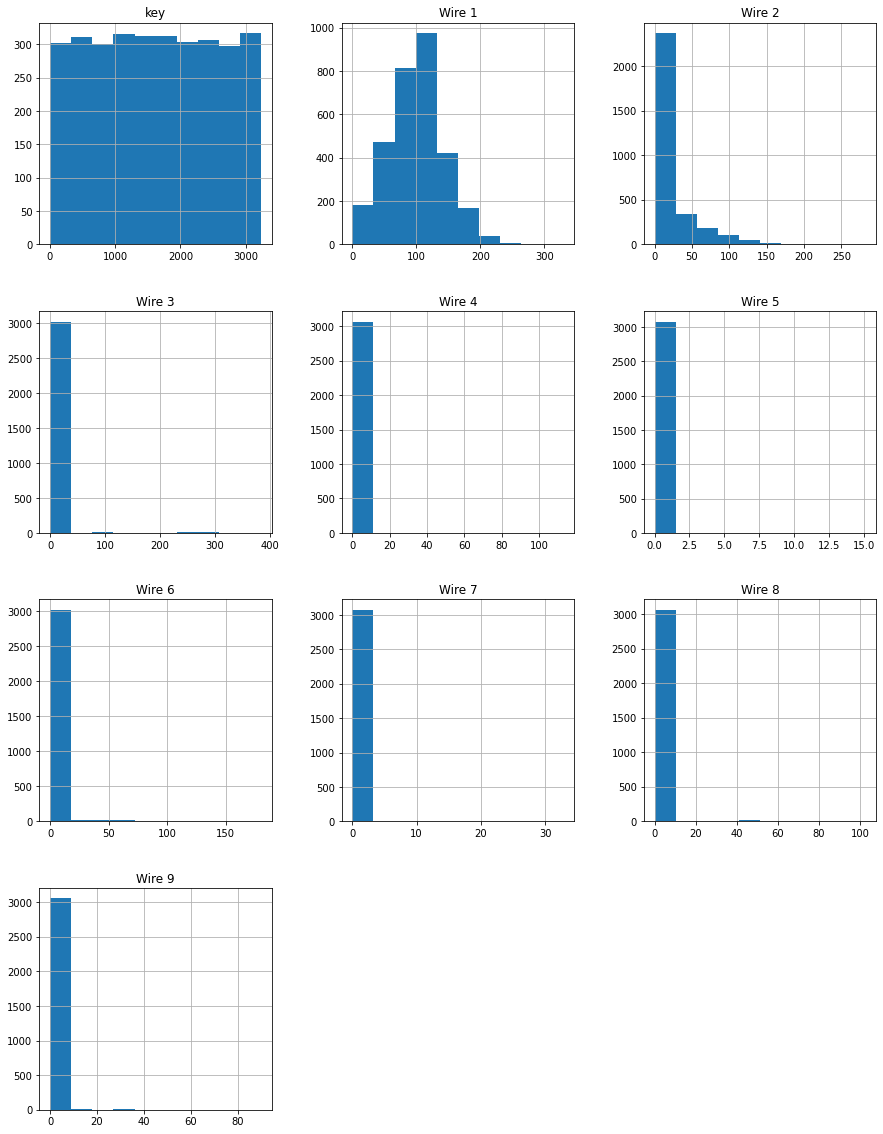

In [133]:
data_wire.hist(figsize=(15, 20))
plt.show()

In [134]:
data_wire_time=pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [136]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<p><u><b>Промежуточный вывод</b></u></p> 

При первоначальном анализе данных выявленно:
1. Нам для анализа дано 7 файлов, в них данные о каждом этапе обработке стали.
2. Есть выбросы, сразу удалила минусовую реактивную мощность, и температуру плавления стали меньше 100 градусов
3. Дубликатов нет.
4. В некоторых данных есть пропуски, пропуски в данных о подаче сыпучих материалов и и проволочных материалов заменила нулем, пропуски в плавлении температуры заменила средним.
5. Необходимо объединение данных по номеру партии, в объединённых партиях будут те ключи, которые есть во всех датафреймах.
6. Добавила новый признак - Полная мощность.
7. Целевым признаком будет последний замер температуры в data_temp


### Подготовка данных для моделирования

In [137]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


In [138]:
data_arc=data_arc.groupby(by = 'key', as_index = False).sum()

In [139]:
data_arc = data_arc.rename(columns={'Активная мощность': 'active power', 'Реактивная мощность': 'reactive power', 'Полная мощность': 'full power' , 'Время нагрева' : 'heating time'})

In [140]:
data_arc.head(5)

,key,active power,reactive power,full power,heating time
0,1,4.878147,3.183241,5.826395,1098
1,2,3.052598,1.998112,3.649216,811
2,3,2.525882,1.599076,2.989534,655
3,4,3.209250,2.060298,3.814962,741
4,5,3.347173,2.252643,4.035758,869


In [141]:
data_arc[['active power', 'reactive power', 
       'full power', 'heating time']].corr()

,active power,reactive power,full power,heating time
active power,1.000000,0.957892,0.993391,0.978012
reactive power,0.957892,1.000000,0.984382,0.966837
full power,0.993391,0.984382,1.000000,0.983356
heating time,0.978012,0.966837,0.983356,1.000000


In [142]:
data_arc = data_arc.drop(['active power', 'reactive power'],axis=1) 

In [143]:
data_arc.head()

,key,full power,heating time
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869


In [144]:
print('Количество пропусков в данных о температуре:',data_arc.isna().sum())

Количество пропусков в данных о температуре: key             0
full power      0
heating time    0
dtype: int64


В данных об электродах несколько строк с одинаковым значением key, нам необходимо, чтобы на 1 ковш была 1 запись. Сгруппировали суммарную полную мощность по ключу. То же самое сделаем с data_temp и выведем первое и  последнее значение

In [145]:
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [146]:
data_temp = data_temp.query('Температура > 1500') 

In [147]:
temp= data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index() 

In [148]:
temp.columns = ['key', 'time first', 'time last', 'temperature first', 'temperature last']

In [149]:
temp = temp.drop(['time first', 'time last'], axis =1)

In [150]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   int64  
 1   temperature first  2477 non-null   float64
 2   temperature last   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.2 KB


Сгруппируем финальную таблицу

In [151]:
final = (temp.merge(data_arc, how='inner', on='key')
         .merge(data_bulk, how='inner', on='key')
         .merge(data_wire, how='inner', on='key')
         .merge(data_gas, how='inner', on='key'))

In [152]:
final.head(5)

,key,temperature first,temperature last,full power,heating time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
0,1,1571.0,1613.0,5.826395,1098,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,3.649216,811,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,2.989534,655,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,3.814962,741,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,4.035758,869,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [153]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2329 non-null   int64  
 1   temperature first  2329 non-null   float64
 2   temperature last   2329 non-null   float64
 3   full power         2329 non-null   float64
 4   heating time       2329 non-null   int64  
 5   Bulk 1             2329 non-null   float64
 6   Bulk 2             2329 non-null   float64
 7   Bulk 3             2329 non-null   float64
 8   Bulk 4             2329 non-null   float64
 9   Bulk 5             2329 non-null   float64
 10  Bulk 6             2329 non-null   float64
 11  Bulk 7             2329 non-null   float64
 12  Bulk 8             2329 non-null   float64
 13  Bulk 9             2329 non-null   float64
 14  Bulk 10            2329 non-null   float64
 15  Bulk 11            2329 non-null   float64
 16  Bulk 12            2329 

In [154]:
print('Количество пропусков в данных о проволочных материалах:',final.isna().sum())

Количество пропусков в данных о проволочных материалах: key                  0
temperature first    0
temperature last     0
full power           0
heating time         0
Bulk 1               0
Bulk 2               0
Bulk 3               0
Bulk 4               0
Bulk 5               0
Bulk 6               0
Bulk 7               0
Bulk 8               0
Bulk 9               0
Bulk 10              0
Bulk 11              0
Bulk 12              0
Bulk 13              0
Bulk 14              0
Bulk 15              0
Wire 1               0
Wire 2               0
Wire 3               0
Wire 4               0
Wire 5               0
Wire 6               0
Wire 7               0
Wire 8               0
Wire 9               0
gas                  0
dtype: int64


Пропуски заменю 0

In [155]:
final = final.fillna(0)

In [156]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2329 non-null   int64  
 1   temperature first  2329 non-null   float64
 2   temperature last   2329 non-null   float64
 3   full power         2329 non-null   float64
 4   heating time       2329 non-null   int64  
 5   Bulk 1             2329 non-null   float64
 6   Bulk 2             2329 non-null   float64
 7   Bulk 3             2329 non-null   float64
 8   Bulk 4             2329 non-null   float64
 9   Bulk 5             2329 non-null   float64
 10  Bulk 6             2329 non-null   float64
 11  Bulk 7             2329 non-null   float64
 12  Bulk 8             2329 non-null   float64
 13  Bulk 9             2329 non-null   float64
 14  Bulk 10            2329 non-null   float64
 15  Bulk 11            2329 non-null   float64
 16  Bulk 12            2329 

<AxesSubplot:>

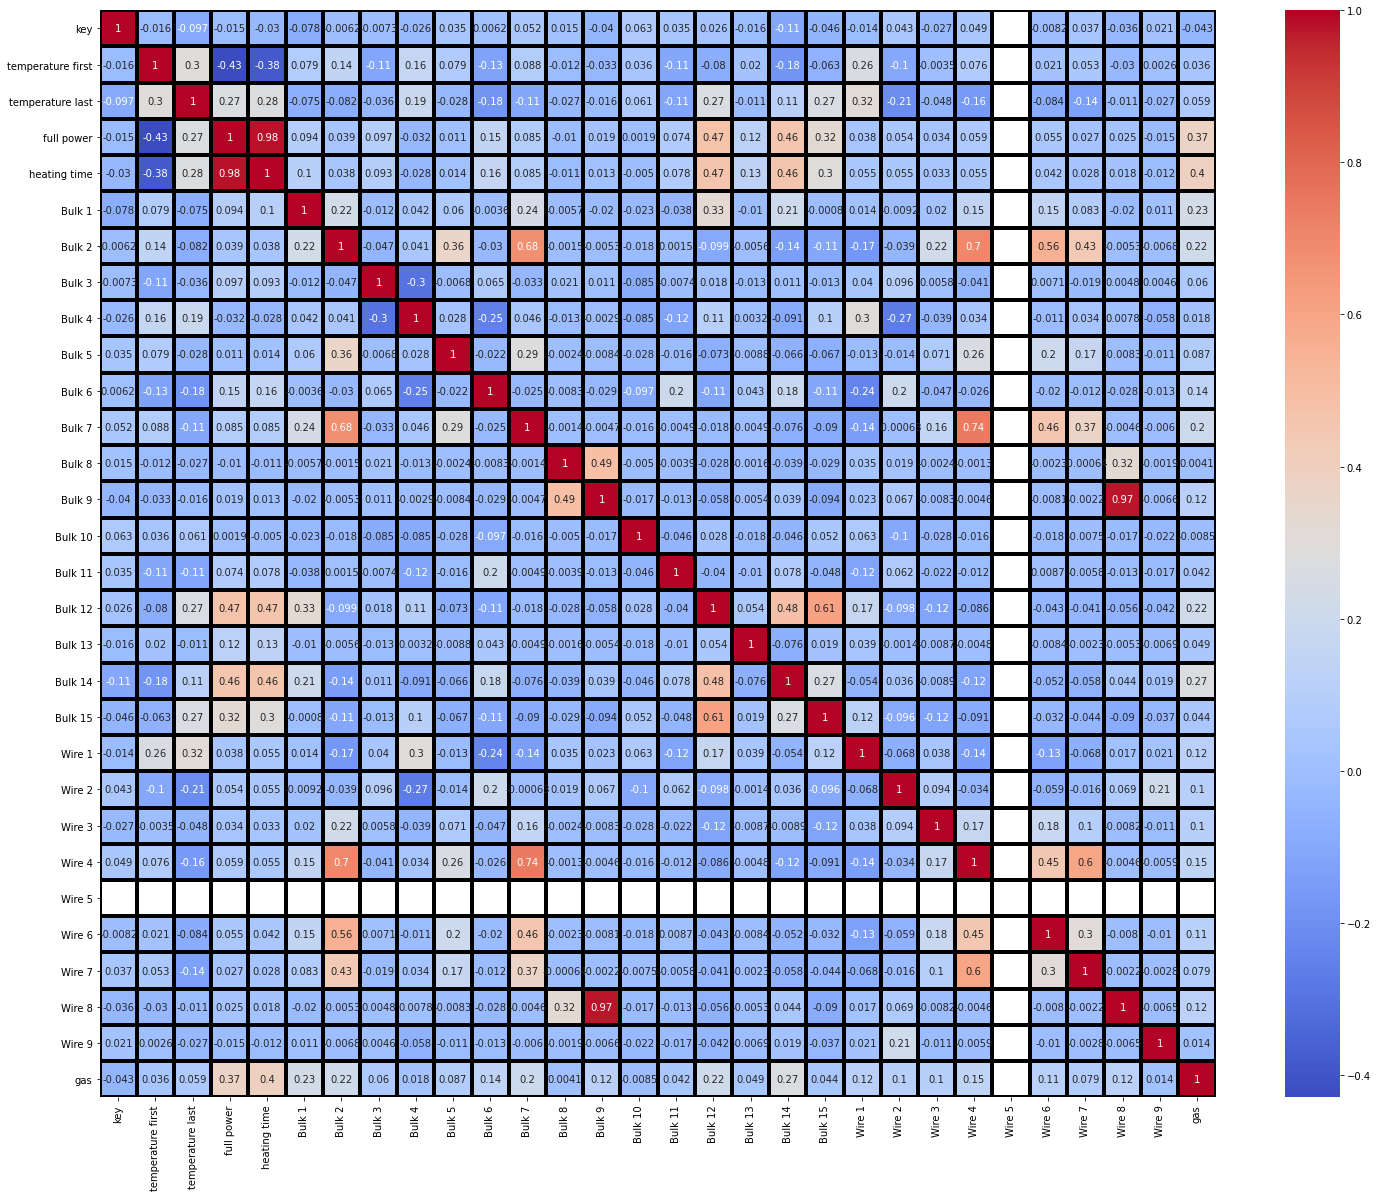

In [157]:
corr = final.corr()
plt.subplots(figsize=(25, 20))
sns.heatmap(final.corr(),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            linewidths=3, linecolor='black',
            annot = True,
            cmap= 'coolwarm')

По корреляционной матрице видим, что полная мощность и время нагрева очень сильно коррелируют между собой. удалю всё таки время нагрева. Также коррелирут сыпучие материалы wire 8 и роволочные материалы bulik 9, удалю один из этих параметров. Также удалю key, для постороения модели не нужен

In [158]:
final = final.drop(['heating time', 'key', 'Wire 5', 'Bulk 9'], axis =1)

<AxesSubplot:>

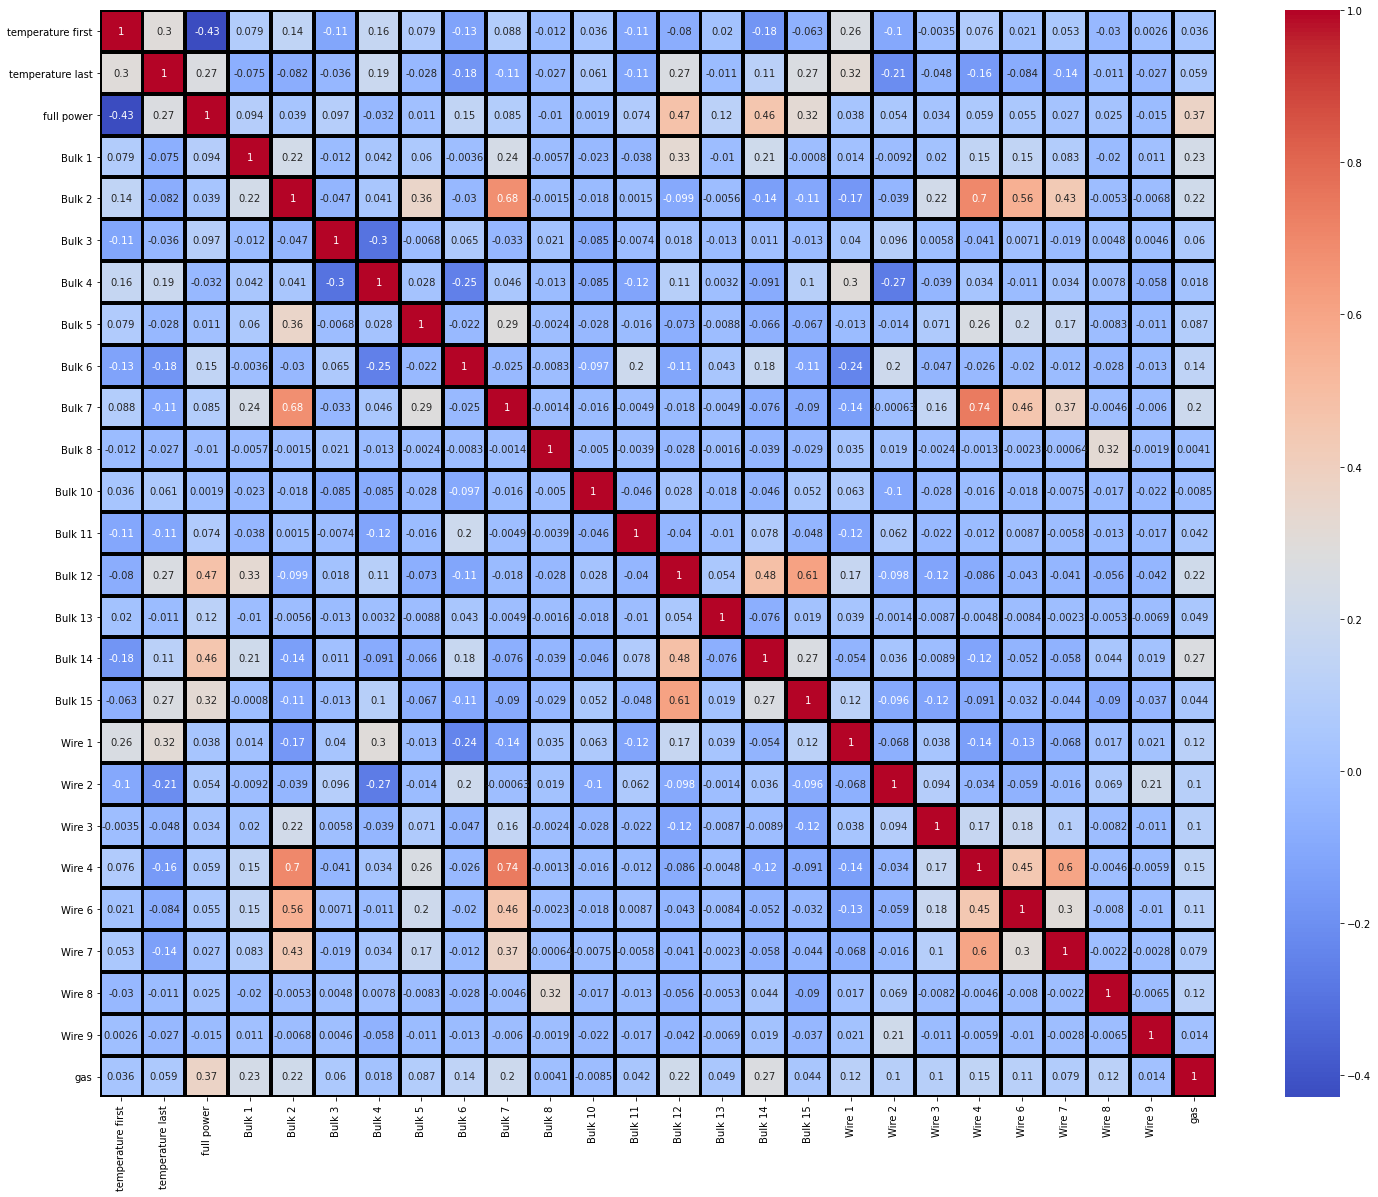

In [159]:
corr = final.corr()
plt.subplots(figsize=(25, 20))
sns.heatmap(final.corr(),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            linewidths=3, linecolor='black',
            annot = True,
            cmap= 'coolwarm')

In [160]:
final

,temperature first,temperature last,full power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,gas
0,1571.0,1613.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,1602.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,1599.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,1625.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1576.0,1602.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,3.986869,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2325,1554.0,1591.0,5.057033,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2326,1571.0,1589.0,2.885017,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2327,1591.0,1594.0,4.143749,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


Разделим данные на обучающую и тестовые выборки

In [161]:
data_train, data_test =train_test_split(final, test_size=0.25, random_state=100423)
print(data_train.shape)
print(data_test.shape)

(1746, 26)
(583, 26)


In [162]:
features_train = data_train.drop(['temperature last'], axis=1) 
target_train = data_train['temperature last']
features_test=data_test.drop(['temperature last'], axis=1)
target_test=data_test['temperature last']

### Обучение модели

#### Линейная регрессия

In [163]:
model = LinearRegression()

print(f'''Значение метрики MAE на обучающей выборке для LinearRegression''', cross_val_score(model, features_train, target_train,
                         n_jobs = -1, 
                         scoring='neg_mean_absolute_error').mean().round(2)*-1)

Значение метрики MAE на обучающей выборке для LinearRegression 6.48


#### Catboost

In [164]:
model_cat = CatBoostRegressor()
parametrs = {'learning_rate': [0.03, 0.1],
             'depth': [4, 6, 10],
             'l2_leaf_reg': [1, 3, 5, 7, 9]}
grid_cat = GridSearchCV(estimator= model_cat, 
                       cv=5, 
                       param_grid=parametrs,  
                       scoring='neg_mean_absolute_error')
grid_cat.fit(features_train, target_train)
grid_cat_parameters = grid_cat.best_params_
print('Лучшие параметры для Catboost', grid_cat_parameters)
print('Лучшая оценка для Catboost', grid_cat.best_score_.round(2)*-1)


0:	learn: 11.2336615	total: 50.6ms	remaining: 50.6s
1:	learn: 11.1585593	total: 53.5ms	remaining: 26.7s
2:	learn: 11.0780294	total: 56.3ms	remaining: 18.7s
3:	learn: 11.0038634	total: 58.9ms	remaining: 14.7s
4:	learn: 10.9361642	total: 61.8ms	remaining: 12.3s
5:	learn: 10.8797251	total: 64.5ms	remaining: 10.7s
6:	learn: 10.7995746	total: 67.3ms	remaining: 9.55s
7:	learn: 10.7258226	total: 70ms	remaining: 8.68s
8:	learn: 10.6587630	total: 72.8ms	remaining: 8.02s
9:	learn: 10.5928241	total: 75.5ms	remaining: 7.48s
10:	learn: 10.5297240	total: 78.3ms	remaining: 7.04s
11:	learn: 10.4582810	total: 81.1ms	remaining: 6.67s
12:	learn: 10.3955446	total: 83.7ms	remaining: 6.35s
13:	learn: 10.3329620	total: 86.5ms	remaining: 6.09s
14:	learn: 10.2695715	total: 89.3ms	remaining: 5.86s
15:	learn: 10.2081052	total: 92.2ms	remaining: 5.67s
16:	learn: 10.1624585	total: 95ms	remaining: 5.49s
17:	learn: 10.1109374	total: 97.7ms	remaining: 5.33s
18:	learn: 10.0659147	total: 100ms	remaining: 5.19s
19:	lear

#### LGBMRegressor

In [88]:
model_LGBM=LGBMRegressor() 
parameters={'n_estimators' : [50, 100],
            'max_depth' : [5, 7, 10]
            }
grid_LGBM= GridSearchCV(estimator = model_LGBM,
                        cv=3,
                        param_grid=parameters,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        verbose=10
                        )
grid_LGBM.fit(features_train, target_train)
grid_LGBM_parameters = grid_LGBM.best_params_
print('Лучшие параметры для LGBMRegressor', grid_LGBM_parameters)
print('Лучшая оценка для LGBMRegressor', grid_LGBM.best_score_.round(2)*-1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_depth=5, n_estimators=50................................
[CV 1/3; 1/6] END ..............max_depth=5, n_estimators=50; total time=  53.5s
[CV 2/3; 1/6] START max_depth=5, n_estimators=50................................
[CV 2/3; 1/6] END ..............max_depth=5, n_estimators=50; total time=  55.4s
[CV 3/3; 1/6] START max_depth=5, n_estimators=50................................
[CV 3/3; 1/6] END ..............max_depth=5, n_estimators=50; total time= 1.2min
[CV 1/3; 2/6] START max_depth=5, n_estimators=100...............................
[CV 1/3; 2/6] END .............max_depth=5, n_estimators=100; total time= 2.3min
[CV 2/3; 2/6] START max_depth=5, n_estimators=100...............................
[CV 2/3; 2/6] END .............max_depth=5, n_estimators=100; total time= 1.8min
[CV 3/3; 2/6] START max_depth=5, n_estimators=100...............................
[CV 3/3; 2/6] END .............max_depth=5, n_est

#### Проверка лучшей модели на тестовой выборке

Лучшая модель - Catboost, проверим её на тесте

In [167]:
result = {
    'Model' : ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'],
    'Train MAE' :pd.Series([7.63, 6.19, 6.47]),
    'Test MAE' :pd.Series([ 0, 6.24, 0]),
    }
display(pd.DataFrame(result))

,Model,Train MAE,Test MAE
0,LinearRegression,7.63,0.00
1,CatBoostRegressor,6.19,6.24
2,LGBMRegressor,6.47,0.00


### Тестирование лучшей модели

In [165]:
model_test_cat = CatBoostRegressor(depth= 10, l2_leaf_reg= 7, learning_rate =  0.03)
model_test_cat.fit(features_train, target_train)
predicted_test_cat= model_test_cat.predict(features_test)
print('MAE для Catboost на тестовой выборке', mean_absolute_error(target_test, predicted_test_cat).round(2))

0:	learn: 10.9946393	total: 46.6ms	remaining: 46.6s
1:	learn: 10.9176601	total: 76.8ms	remaining: 38.3s
2:	learn: 10.8436204	total: 104ms	remaining: 34.6s
3:	learn: 10.7692680	total: 129ms	remaining: 32.2s
4:	learn: 10.6918131	total: 154ms	remaining: 30.7s
5:	learn: 10.6178895	total: 180ms	remaining: 29.8s
6:	learn: 10.5535459	total: 206ms	remaining: 29.3s
7:	learn: 10.4756343	total: 232ms	remaining: 28.7s
8:	learn: 10.4158488	total: 258ms	remaining: 28.4s
9:	learn: 10.3525648	total: 289ms	remaining: 28.6s
10:	learn: 10.2876372	total: 313ms	remaining: 28.2s
11:	learn: 10.2200519	total: 339ms	remaining: 27.9s
12:	learn: 10.1517036	total: 365ms	remaining: 27.7s
13:	learn: 10.0912719	total: 391ms	remaining: 27.5s
14:	learn: 10.0322332	total: 417ms	remaining: 27.4s
15:	learn: 9.9675889	total: 443ms	remaining: 27.3s
16:	learn: 9.9067739	total: 470ms	remaining: 27.2s
17:	learn: 9.8608002	total: 500ms	remaining: 27.3s
18:	learn: 9.8020417	total: 525ms	remaining: 27.1s
19:	learn: 9.7548266	tot

#### Анализ важности факторов

Learning rate set to 0.044712
0:	learn: 10.9519344	total: 3.05ms	remaining: 3.05s
1:	learn: 10.8425265	total: 5.71ms	remaining: 2.85s
2:	learn: 10.7113169	total: 8.29ms	remaining: 2.76s
3:	learn: 10.5927678	total: 10.8ms	remaining: 2.7s
4:	learn: 10.4874230	total: 15.2ms	remaining: 3.02s
5:	learn: 10.4109611	total: 19.4ms	remaining: 3.22s
6:	learn: 10.3054872	total: 23.7ms	remaining: 3.36s
7:	learn: 10.2123102	total: 28ms	remaining: 3.47s
8:	learn: 10.1070744	total: 32ms	remaining: 3.53s
9:	learn: 10.0311078	total: 36.4ms	remaining: 3.6s
10:	learn: 9.9659101	total: 39.4ms	remaining: 3.54s
11:	learn: 9.8879455	total: 42ms	remaining: 3.46s
12:	learn: 9.8139631	total: 44.4ms	remaining: 3.37s
13:	learn: 9.7530849	total: 46.8ms	remaining: 3.3s
14:	learn: 9.6770341	total: 49.6ms	remaining: 3.26s
15:	learn: 9.6052448	total: 52.3ms	remaining: 3.21s
16:	learn: 9.5310974	total: 55.3ms	remaining: 3.19s
17:	learn: 9.4575505	total: 57.9ms	remaining: 3.16s
18:	learn: 9.3903519	total: 60.6ms	remainin

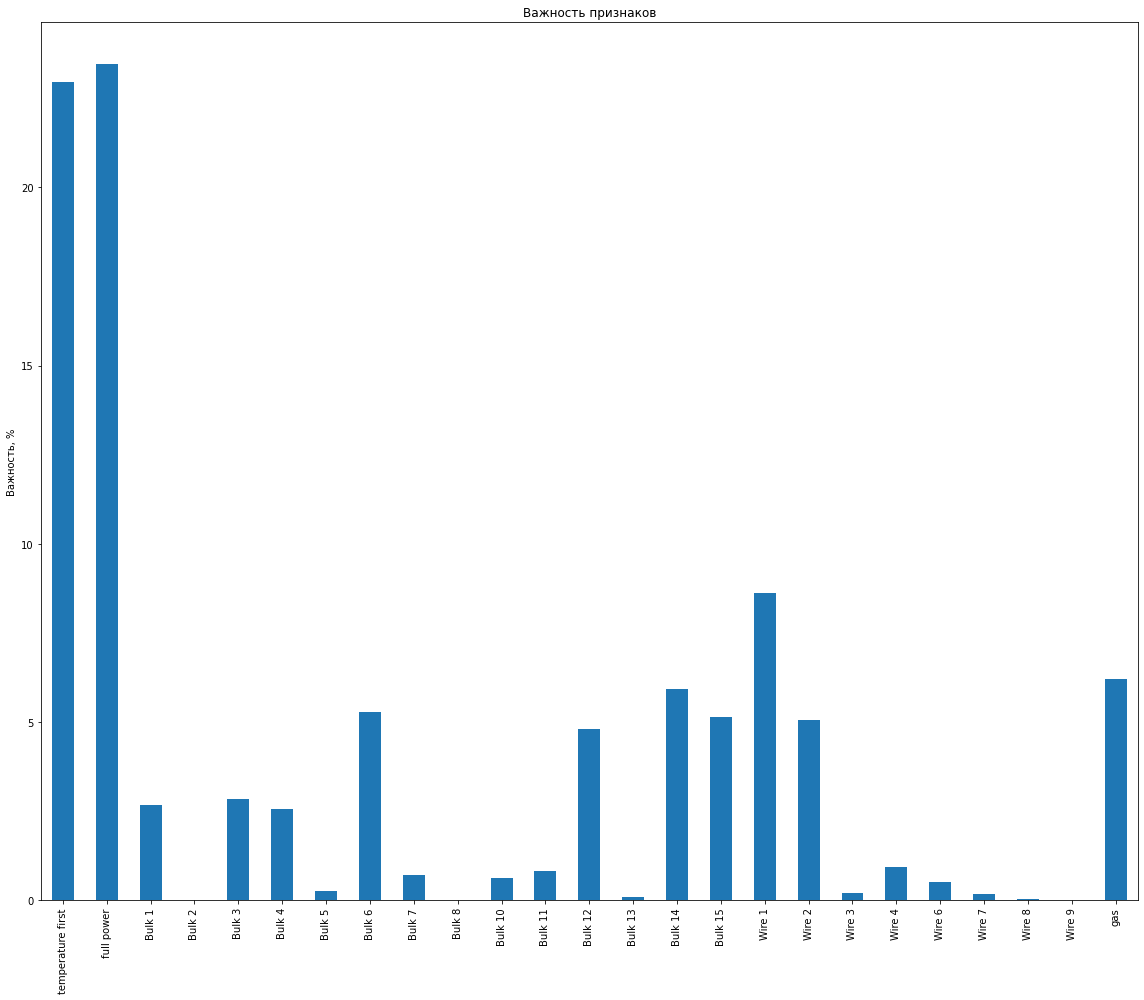

In [166]:
model_cat.fit(features_train, target_train)
cat_iris_imp = pd.Series(model_cat.get_feature_importance(),
                        final.drop(['temperature last'], axis = 1).columns)

fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Лучшую метрику показала модель CatBoostRegressor - 6.18. А это значит что мы достигли желаемого качества (метрика меньше 6,8). При анализе факторов вазности выявлено, что больше всего на конечную температуру влияют :полная мощность, начальная температура и объём проволочных материалов (wire 1) 

# ИТОГОВЫЙ ВЫВОД

Заказчиком ООО «Так закаляем сталь» была поставлена задача - уменьшить потребление электроэнергии на этапе обработки стали. Нам было необходимо построить модель, которая предскажет температуру стали.

Был описан процесс производства и предоставленны данные из семи источников, каждый из которых показывал наблюдения на разных этапах производства: данные об электродах, данные о подаче сыпучих материалов (объём), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём), а также периоды (время и дата), когда производились итерации.

Основная сложность возникла в понимании процесса производства, долго разбиралась почему повторяются номера партии и как это решить, но после встречи с заказчиком на основные вопросы были даны ответы и стало понятно в каком направлении двигаться. 

В процессе работы было сделано:

#### Изучение данных и их предобработка

 - При первичном изучении данных было замечено много пропусков, особенно в данных о подаче сыпучих и проволочных материалов, также в данных о температуре, поменяла тип данных даты и времени.

- Удалила явные выбросы (минусовую мощность и температуру плавления стали меньше 100 градусов)

- Был добавленновый признак - полная мощность (изначально были данные только об активной и реактивной мощности)

- Выявлен целевой признак -температура. Также было замечено, что в некоторых партиях не было измерения температуры, эти партии решила удалить

- Так как конечную таблицу необходимо было составить по номеру партии, а в данных об электродах номера партии повторялись, я агрегировала номера партии по мощности (то есть по каждой партии суммировала полную мощность)

- Также для целевого признака нам необходимы были данные именно последнего измерения температуры, поэтому оставила для финальных данных только первое и последнее температуры(промежуточные удалила)

- Сгруппировала финальную таблицу, построила корреляционную матрицу и удалила признаки которые сильно коррелируют друг с другом

- В финальных данных осталось 2329 наблюдений и 25 признаков: temperature first	temperature last	full power	Bulk 1	Bulk 2	Bulk 3	Bulk 4	Bulk 5	Bulk 6	Bulk 7	...	Bulk 15	Wire 1	Wire 2	Wire 3	Wire 4	Wire 6	Wire 7	Wire 8	Wire 9	gas . Целевой признак-финальное измерение температуры -temperature last

#### Модели

Было обучено 3 модели : Линейная регрессия, CatBoostRegressor, LGBMRegressor. 

Было предложено использовать метрику абсолютных ошибок MAE, её значение должно быть меньше или равно 6.8

Желаемый результат показали на обучающих данных две модели CatBoostRegressor и  LGBMRegressor. Их значение MAE 6.19 и 6.48 соответственно. Но так как Catboost показал лучше результатт, эту модель и проверила на тестовых данных, на тесте MAE = 6.24.

Лучщие гиперпараметры для модели CatBoostRegressor: depth: 6, l2_leaf_reg: 5, learning_rate: 0.03, random_state = 100423

После анализа факторов, для улучшения качества модели, я бы удалила некоторые признаки, которые не влияют или мало влияют на конечный результат